In [1]:
library(keras) 
library(tensorflow) 
library(magick) 
library(imager) 
library(purrr)


Linking to ImageMagick 6.9.11.60
Enabled features: fontconfig, freetype, fftw, heic, lcms, pango, webp, x11
Disabled features: cairo, ghostscript, raw, rsvg



Using 4 threads



Loading required package: magrittr




Attaching package: ‘imager’




The following object is masked from ‘package:magrittr’:

    add




The following objects are masked from ‘package:stats’:

    convolve, spectrum




The following object is masked from ‘package:graphics’:

    frame




The following object is masked from ‘package:base’:

    save.image





Attaching package: ‘purrr’




The following object is masked from ‘package:magrittr’:

    set_names




In [2]:
train_dir <- '../input/files1/Malaria Cells/training_set'
test_dir <- '../input/files1/Malaria Cells/testing_set'

In [3]:
image_shape <- c(130,130,3) 

In [4]:
model <- keras_model_sequential()%>%
    layer_conv_2d(filters = 6 , kernel_size = c(9,9),input_shape = image_shape , 
                 activation = 'relu')%>%
layer_max_pooling_2d(pool_size = c(2,2))%>%
layer_conv_2d(filters = 12 , kernel_size = c(32,32) , input_shape = image_shape,
              activation = 'relu')%>%
layer_max_pooling_2d(pool_size = c(2,2))%>%
layer_conv_2d(filters = 6 , kernel_size = c(9,9), input_shape = image_shape 
             , activation = 'relu')%>%
layer_max_pooling_2d(pool_size = c(2,2))%>%
layer_flatten()%>%
layer_dense(1 , activation = 'sigmoid')%>%
layer_dropout(0.5)

In [5]:
model %>% 
    compile(loss = 'binary_crossentropy',
           optimizer = optimizer_sgd(),
           metrics = c('acc')) 
print(model)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 conv2d_2 (Conv2D)                  (None, 122, 122, 6)             1464        
 max_pooling2d_2 (MaxPooling2D)     (None, 61, 61, 6)               0           
 conv2d_1 (Conv2D)                  (None, 30, 30, 12)              73740       
 max_pooling2d_1 (MaxPooling2D)     (None, 15, 15, 12)              0           
 conv2d (Conv2D)                    (None, 7, 7, 6)                 5838        
 max_pooling2d (MaxPooling2D)       (None, 3, 3, 6)                 0           
 flatten (Flatten)                  (None, 54)                      0           
 dense (Dense)                      (None, 1)                       55          
 dropout (Dropout)                  (None, 1)                       0           
Total params: 81,097
Trainable params: 81,097
Non-trainable params: 0
___________________

In [6]:
train_datagen <- image_data_generator(rescale = 1/255) 
test_datagen <- image_data_generator(rescale = 1/255) 
batch <- 8 

train_generator <- flow_images_from_directory(directory = train_dir , generator = train_datagen , 
                                             batch_size = batch , class_mode = 'binary', target_size = c(image_shape[1:2]))
test_generator <- flow_images_from_directory(directory = test_dir , generator = test_datagen , batch_size = batch , class_mode = 'binary', target_size = c(image_shape[1:2]))

In [7]:
time <- system.time(history <- model %>% fit_generator(train_generator,steps_per_epoch = 150 , epochs = 5 , validation_data = test_generator))

Warning message in fit_generator(., train_generator, steps_per_epoch = 150, epochs = 5, :
“`fit_generator` is deprecated. Use `fit` instead, it now accept generators.”


In [8]:
time

   user  system elapsed 
147.330  17.332 208.854 

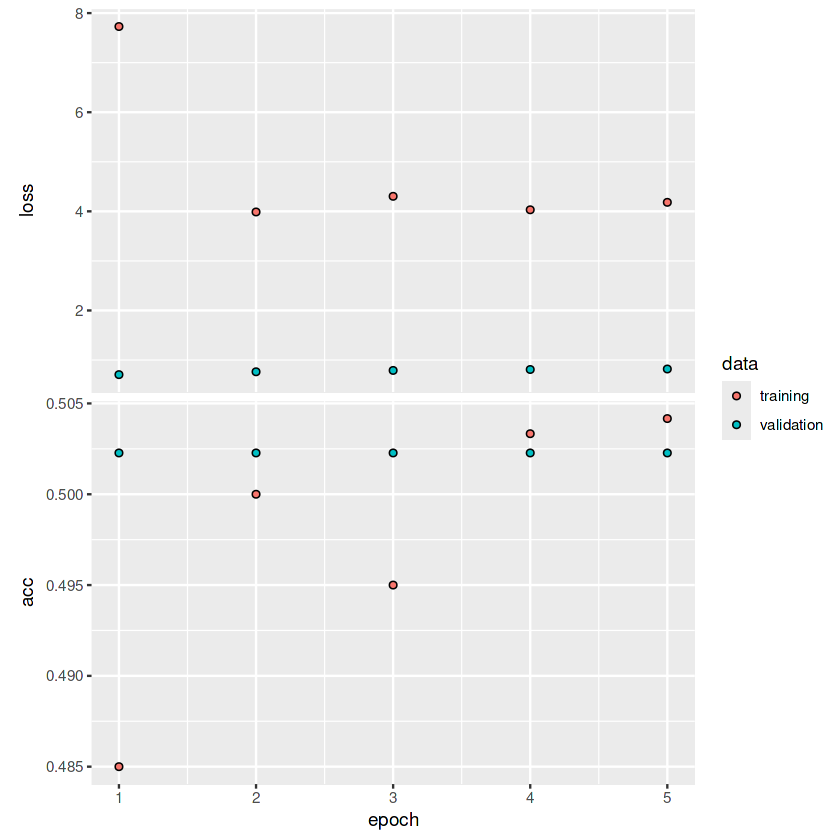

In [9]:
plot(history)

In [10]:
library(dplyr) 
library(grid) 
library(sys) 
library(abind) 
library(fs) 



Attaching package: ‘dplyr’




The following object is masked from ‘package:imager’:

    where




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘grid’




The following object is masked from ‘package:imager’:

    depth




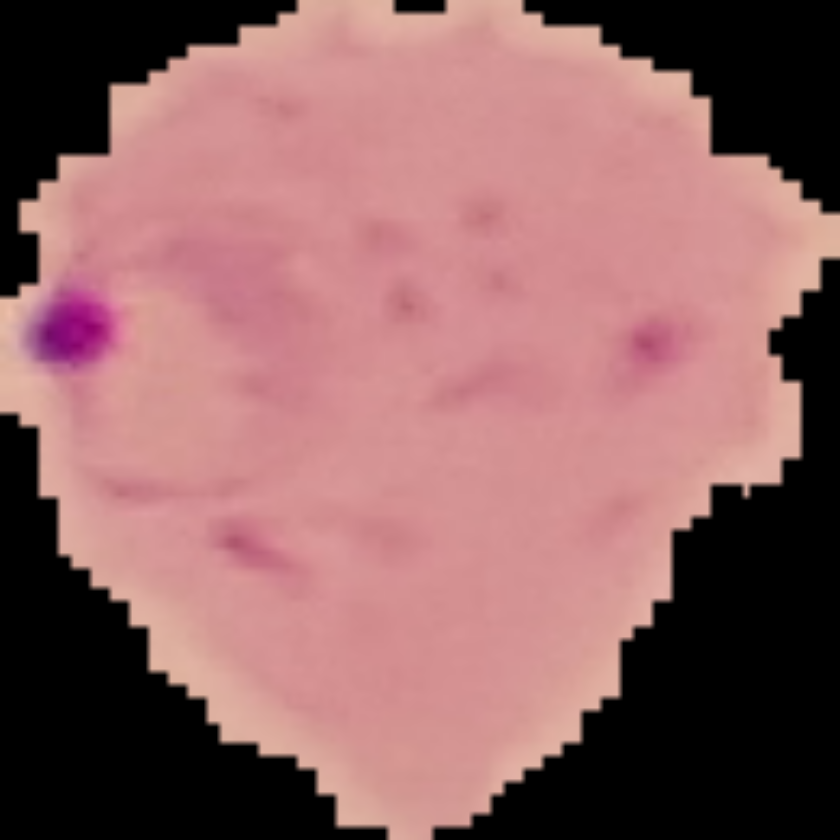

In [11]:
test_parsite <- dir_ls(path = paste0(test_dir, '/Parasitized'), glob = '*.png') 
test_uninfected <- dir_ls(path = paste0(test_dir , '/Uninfected'), glob = '*.png') 

image_data_generator() 

pred_img <- test_parsite[100] 

img_new <- image_load(pred_img , target_size = c(image_shape[1:2])) 

pred_img <- image_to_array(img_new) 
img_tensor <- array_reshape(pred_img , c(1  , image_shape)) 

img_tensor <- img_tensor / 255 
grid.raster(img_tensor[1,,,])

In [12]:
predval <- predict(model , img_tensor) 
